In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pprint import pprint
import os.path as pth

import gzip
import pickle

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Flatten, Reshape
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split, KFold, GroupKFold

from util import downscale_img

from config import *

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
ROOT_DIR = '../data'
TRAIN_IMG_DIR = pth.join(ROOT_DIR, 'original/train_images')
TRAIN_DATA_DIR = ROOT_DIR

In [4]:
data = pd.read_feather(pth.join(TRAIN_DATA_DIR, 'train.feather'))

/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [5]:
image_groups = data.groupby('imageid')

s = image_groups[['mask_present']].sum().mask_present
s.name = 'nmasks'
data = data.merge(s, left_on=['imageid'], right_index=True)

In [6]:
data.head()

,imageid,classid,mask_present,nmasks
0,0002cc93b,1,True,1.0
1,0002cc93b,2,False,1.0
2,0002cc93b,3,False,1.0
3,0002cc93b,4,False,1.0
4,00031f466,1,False,0.0


In [7]:
with gzip.open(pth.join(TRAIN_DATA_DIR, 'train_masks.pickle.gz'), 'rb') as f:
    image_masks = pickle.load(f)

In [8]:
image_masks_scaled = {}
for k in image_masks:
    image_masks_scaled[k] = downscale_img(image_masks[k])

from loaders import BlockwiseImageLoader
n = 4
b = BlockwiseImageLoader(train_cv_image_names[0:10], image_groups, image_masks, n, 128, 64)
img_patches, mask_patches = b[0]
imgs = b.combine_patches(img_patches)

for i in range(n):
    name = train_cv_image_names[i]
    im = plt.imread(pth.join(TRAIN_IMG_DIR, f'{name}.jpg')).astype('float32')[:, :, 0]
    plt.figure()
    plt.imshow(im, cmap='gray')
    plt.show()
    plt.figure()
    plt.imshow(imgs[i], cmap='gray')
    plt.show()


In [9]:
from models import SimpleAE, SimpleInception, UNet

OUTPUT_CHANNEL = 1
NUM_OUTPUTS = 4 if OUTPUT_CHANNEL is None else 1

model = UNet(4, 64, num_outputs=NUM_OUTPUTS)
model.build_model()
#model.summary()

W0909 07:13:17.825579 140062316627776 deprecation.py:506] From /home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0909 07:13:18.464250 140062316627776 deprecation.py:323] From /home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


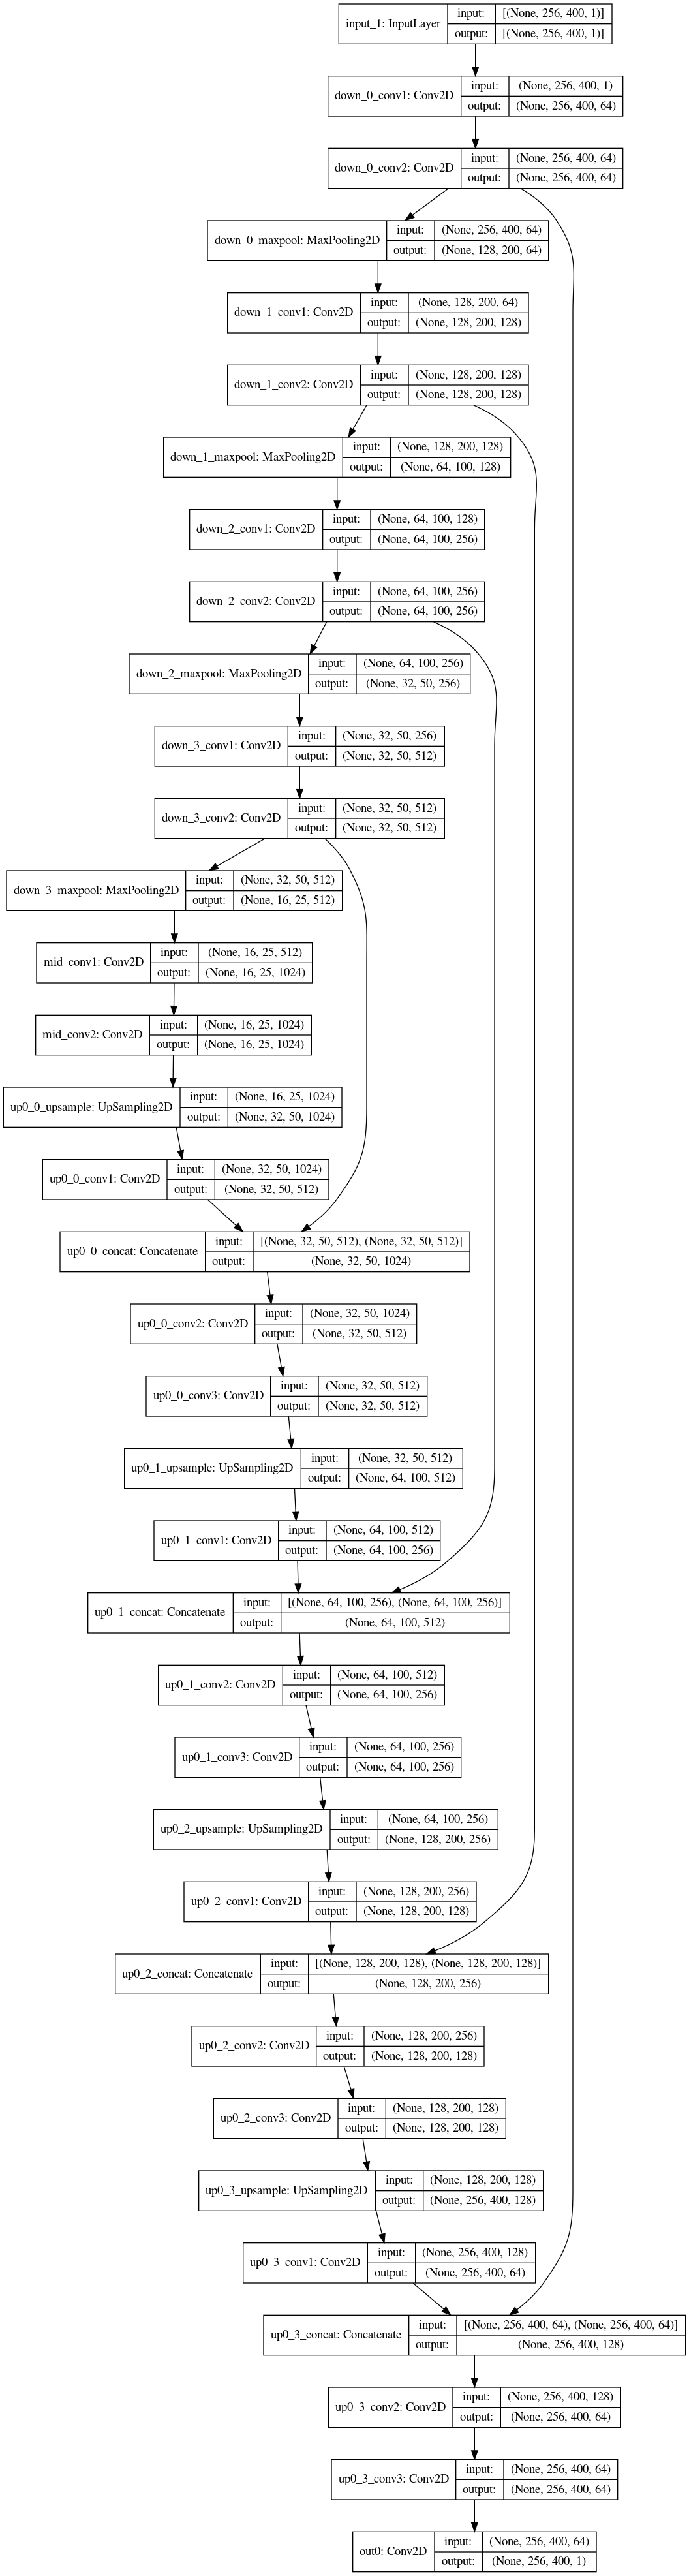

In [10]:
tf.keras.utils.plot_model(
    model.model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

In [24]:
n = 10000
if OUTPUT_CHANNEL is None:
    image_names = list(data[data.nmasks > 0].imageid.unique())[0:n]
else:
    image_names = list(data[(data.classid == OUTPUT_CHANNEL) & data.mask_present].imageid.unique())[0:n]

train_cv_image_names, test_image_names = train_test_split(image_names)
len(train_cv_image_names), len(test_image_names)

(672, 225)

from loaders import ImageLoader

n = 10
loader = ImageLoader(train_cv_image_names[0:n], image_groups, image_masks_scaled, 1)
for i in range(n):
    im = loader[i][0].squeeze()
    print(im.shape, im.min(), im.max())
    plt.figure()
    plt.imshow(im, cmap='gray')
    plt.show()

In [25]:
from loaders import ImageLoader, BlockwiseImageLoader
from config import *

BATCH_SIZE = 1
#PATCH_SIZE = 64
#PATCH_STRIDE = 32

kfold = KFold(10)

for train_indices, cv_indices in kfold.split(train_cv_image_names):
    train_image_names = [train_cv_image_names[i] for i in train_indices]
    cv_image_names = [train_cv_image_names[i] for i in cv_indices]
    print(f'{len(train_image_names)} training samples, {len(cv_image_names)} validation samples')
    model.fit_generator(
        generator=ImageLoader(train_image_names, image_groups, image_masks_scaled, 
                              BATCH_SIZE, output_channel=OUTPUT_CHANNEL),#, PATCH_SIZE, PATCH_STRIDE),
        validation_data=ImageLoader(cv_image_names, image_groups, image_masks_scaled, 
                                    BATCH_SIZE, output_channel=OUTPUT_CHANNEL),#, PATCH_SIZE, PATCH_STRIDE),
        epochs=20)

604 training samples, 68 validation samples
Epoch 1/20
604/604 [==============================] - 78s 129ms/step - loss: 0.0451 - acc: 0.9894 - val_loss: 0.0369 - val_acc: 0.9884
Epoch 2/20
604/604 [==============================] - 78s 130ms/step - loss: 0.0337 - acc: 0.9895 - val_loss: 0.0311 - val_acc: 0.9887
Epoch 3/20
604/604 [==============================] - 79s 130ms/step - loss: 0.0300 - acc: 0.9899 - val_loss: 0.0297 - val_acc: 0.9893
Epoch 4/20
604/604 [==============================] - 79s 130ms/step - loss: 0.0295 - acc: 0.9903 - val_loss: 0.0263 - val_acc: 0.9903
Epoch 5/20
604/604 [==============================] - 79s 130ms/step - loss: 0.0270 - acc: 0.9908 - val_loss: 0.0260 - val_acc: 0.9904
Epoch 6/20
604/604 [==============================] - 79s 130ms/step - loss: 0.0265 - acc: 0.9911 - val_loss: 0.0266 - val_acc: 0.9903
Epoch 7/20
604/604 [==============================] - 79s 130ms/step - loss: 0.0254 - acc: 0.9912 - val_loss: 0.0247 - val_acc: 0.9907
Epoch 8/20


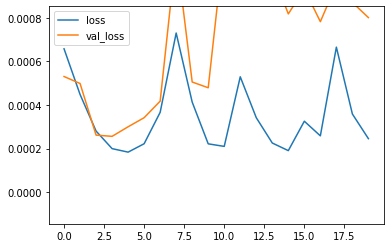

In [26]:
model.plot_history()

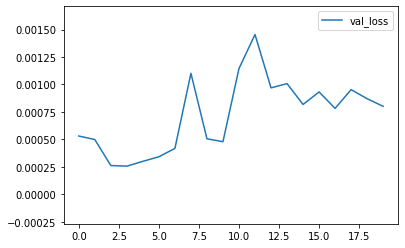

In [27]:
model.plot_history(['val_loss'])

In [28]:
names = test_image_names[0:10]
loader = ImageLoader(names, image_groups, image_masks_scaled,
                     BATCH_SIZE)#, PATCH_SIZE, PATCH_STRIDE)
results = model.predict_generator(generator=loader)
#results = loader.combine_mask_patches(results)


459840244


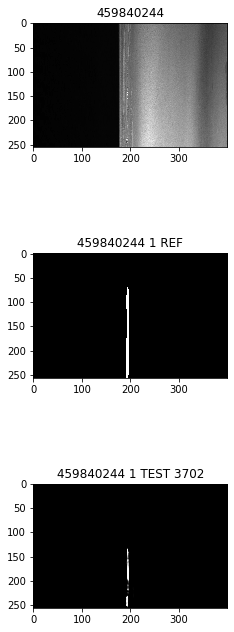


2c18ac76d


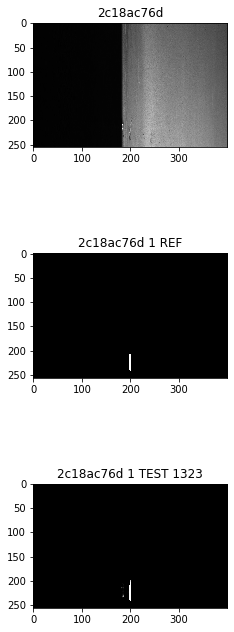


1e95fc3d7


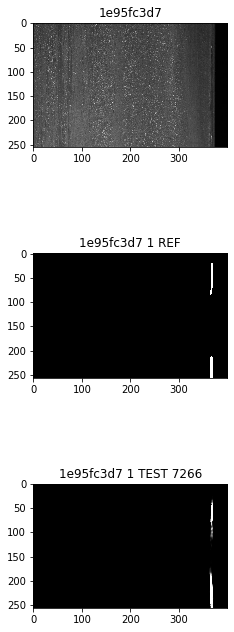


bb765d50c


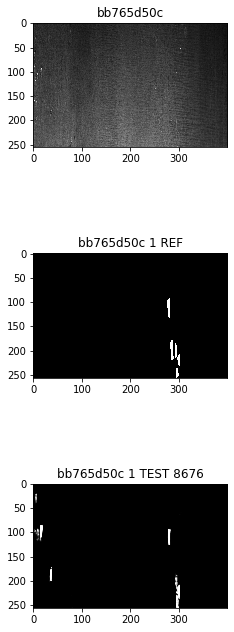


5d2fe9f45


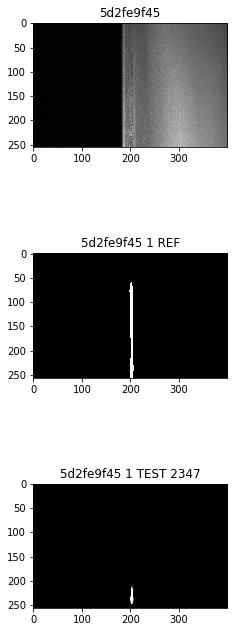


37df5752a


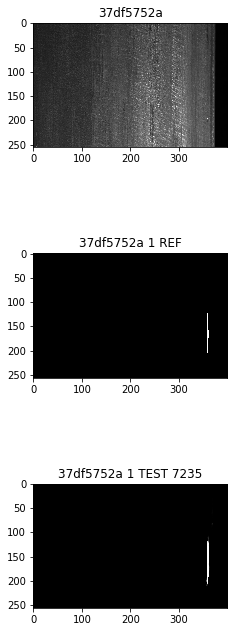


47f5c8e07


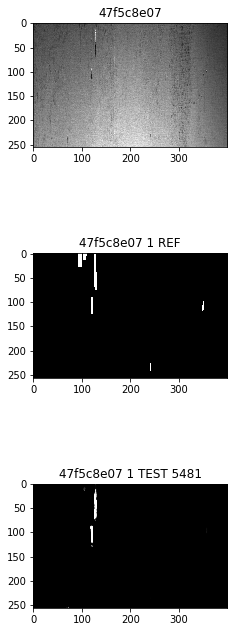


f6d99d582


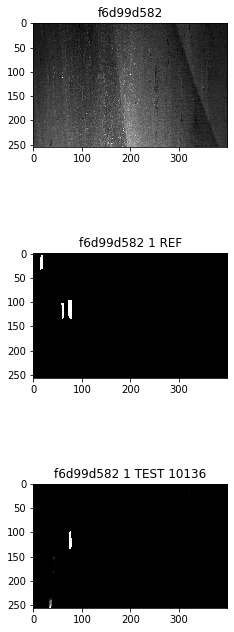


7bb25cc94


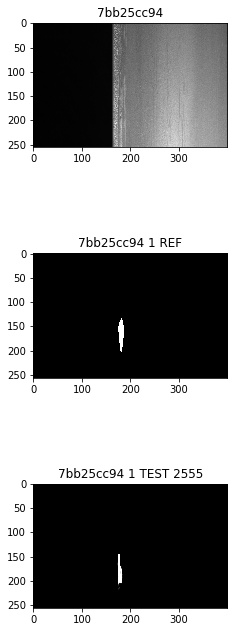


59849c3de


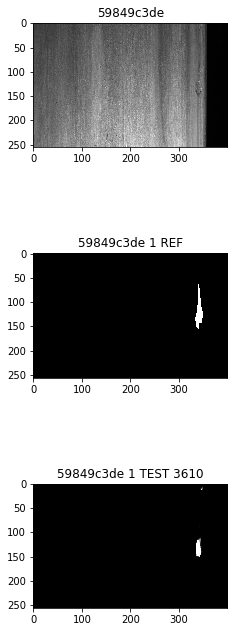

In [29]:
for i, name in enumerate(names):
    im = plt.imread(pth.join(TRAIN_IMG_DIR, f'{name}.jpg')).astype('float32')[:, :, 0]
    im = downscale_img(im)
    
    print('')
    print(name)
    plt.figure(figsize=(16, 12))
    
    plt.subplot(3, 4, 1)
    plt.title(name)
    plt.imshow(im, cmap='gray')
    
    outputs = [1, 2, 3, 4] if OUTPUT_CHANNEL is None else [OUTPUT_CHANNEL] 
    for j in outputs:
        rows = data[(data.imageid == name) & (data.classid == j)]
        row = rows.iloc[0, :]

        if row.mask_present:
            mask_ref = image_masks_scaled[f'{name}_{j}']
        else:
            mask_ref = np.zeros((SCALED_HEIGHT, SCALED_WIDTH), dtype='uint8')
            
        plt.subplot(3, 4, 4 + j)
        plt.title(f'{name} {j} REF')
        plt.imshow(mask_ref, cmap='gray')
        
        #continue
        #mask_test = results[j - 1][i].squeeze()
        mask_test = results[i].squeeze()
        #mask_test = (mask_test > 0.5).astype('uint8')
        
        
        plt.subplot(3, 4, 8 + j)
        plt.title(f'{name} {j} TEST {np.sum(mask_ref != mask_test)}')
        plt.imshow(mask_test, cmap='gray')
        
    plt.show()
